In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import requests
import json
from pprint import pprint
import networkx as nx

import arabic_reshaper
from bidi.algorithm import get_display
from matplotlib.pyplot import *

# task 1 (Get the title and tags of all theses related to a specific proffesor from IranDoc)

## Generating URLs

In [2]:
scholar_first_name = 'محمد'
scholar_last_name = 'اقدسی'
response = requests.get(f'https://ganj.irandoc.ac.ir/api/v1/search/main?basicscope=5&fulltext_status=1&keywords={scholar_first_name}+{scholar_last_name}&results_per_page=4&sort_by=2&year_from=0&year_to=1400')
page_num = json.loads(response.text)['total_pages']

# creat a list of urls based on scholar's name and page number
urls = []
for i in range(1, page_num+1):
    base_url = f'https://ganj.irandoc.ac.ir/api/v1/search/main?basicscope=5&fulltext_status=1&keywords={scholar_first_name}+{scholar_last_name}&page={i}&results_per_page=4&sort_by=2&year_from=0&year_to=1400'
    urls.append(base_url)

print(*urls, sep=f"\n{79*'-'}\n")

https://ganj.irandoc.ac.ir/api/v1/search/main?basicscope=5&fulltext_status=1&keywords=محمد+اقدسی&page=1&results_per_page=4&sort_by=2&year_from=0&year_to=1400
-------------------------------------------------------------------------------
https://ganj.irandoc.ac.ir/api/v1/search/main?basicscope=5&fulltext_status=1&keywords=محمد+اقدسی&page=2&results_per_page=4&sort_by=2&year_from=0&year_to=1400
-------------------------------------------------------------------------------
https://ganj.irandoc.ac.ir/api/v1/search/main?basicscope=5&fulltext_status=1&keywords=محمد+اقدسی&page=3&results_per_page=4&sort_by=2&year_from=0&year_to=1400


## Define custome functions

In [3]:
# Define a function to make farsi text to be shown correctly
def farsify(text):
    return get_display(arabic_reshaper.reshape(u'%s' % str(text)))

def duplicate_remover(a_list):
    list_ = []
    for item in a_list:
        if item not in list_:
            list_.append(item)
    return list_

### Extracting Thesis Titles and Tags

In [4]:
# request and return the result of all url(s) and deseralize them as well
all_page_results = [json.loads(requests.get(i).text) for i in urls]

counter_thesis = 1
theses = {}

for page in all_page_results:
    for thesis in page['results']:
#         print(f"{counter_thesis}. عنوان پایان نامه: \n\n", thesis['title'])
#         print("\n----------------tags---------------\n")
        
        # get all the tags for each thesis
        thesis_tag_url = 'https://ganj.irandoc.ac.ir/api/v1/articles/'+thesis['uuid']+'/show_tags'
        response = requests.get(thesis_tag_url)
        all_thesis_tags = json.loads(response.text)
        
        # creat a list of all tags for each thesis
        thesis_tags_farsi = [tag['title_fa'] for tag in all_thesis_tags['tags']]
#         thesis_tags_en = [tag['title_en'] for tag in all_thesis_tags['tags']]

#         print(*thesis_tags_farsi, sep="\n")
#         print(79*"=")
        
        theses[counter_thesis] = {"uuid": thesis['uuid'], "title": thesis['title'], "tags": thesis_tags_farsi}
        
        counter_thesis += 1

## check the result of extracting the title and tags of all theses

In [5]:
# pprint(theses)

# for num in range(1, len(theses)+1):
#     print(f"{counter_thesis}. عنوان پایان نامه: \n\n", theses[num]['title'])
    
#     print("\n----------------tags---------------\n")
#     print(*theses[num]['tags'], sep="\n")
#     print(79*"=")

print(theses[1])

{'uuid': 'e1160ca77a8b019975fec7d1f7d2241c', 'title': 'ارزیابی هماهنگی در اجرای پروژه های ساختمانی و عملکرد BIM در این رابطه', 'tags': ['هماهنگی', 'مدیریت منابع', 'مدل سازی اطلاعات ساختمان', 'یکپارچه سازی اطلاعات']}


## Plot tags frequency

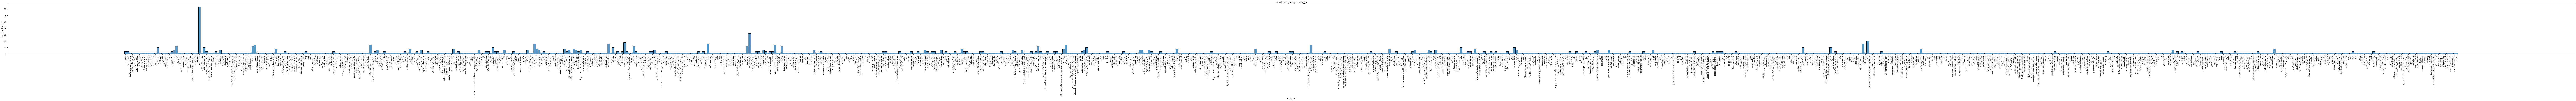

In [6]:
# merge all the tags to plot their frequency
tags_farsify = [farsify(tag) for thesis in theses for tag in theses[thesis]['tags']]
# titles_farsify = [farsify(theses[thesis]['title']) for thesis in theses]

fig, ax = plt.subplots(figsize=(250, 5))

# plt.hist(tag_list_final, ax=ax)
plt.ylabel(farsify("فراوانی کلید واژه ها"))
plt.xlabel(farsify("کلید واژه ها"))
plt.title(farsify("حوزه های کاری دکتر محمد اقدسی"))
ax.tick_params(axis='x', rotation=90)

ax = sns.histplot(data=tags_farsify, palette="Set3", ax=ax)

plt.show()

# task 2 (import theses and their tags as nodes in Gephi)

## Create an affiliation matrix
### with theses titles as rows and all the tags as columns

In [16]:
# # use farsify just for plotting since the original tags, in theses dict, are not farsify
# # and they cannot be compared together later on
# titles = [theses[thesis]['title'] for thesis in theses]
titles = [theses[thesis]['uuid'] for thesis in theses]
tags = [tag for thesis in theses for tag in theses[thesis]['tags']]

# # for full name titles as rows
dataset_rows = titles
# for numbers instead of title names
# dataset_rows = theses.keys()

# we use duplicate_remover to remove any duplicate
# and have a clean list of all tags in theses
dataset_cols = duplicate_remover(tags)
# print(len(tags), "-", len(dataset_cols))


df = pd.DataFrame(columns=dataset_cols, index=dataset_rows)

df

,هماهنگی,مدیریت منابع,مدل سازی اطلاعات ساختمان,یکپارچه سازی اطلاعات,فرآیند کسب‌و‌کار,مشکلات تحلیل فرآیند,تامین کنندگان,فرآیندهای داخلی,ارتباطات با مشتریان,فرآیندکاوی آموزشی,...,توسعه صنعتی,روش‌های تولید,طرح‌های توسعه,بسپار سیلیکونی,تکنولوژی گروهی,سیستم‌های تولیدی,شبیه‌سازی کامپیوتری,مدلسازی فرایند,فرایند خدمات ارتوپدی,سلامت
e1160ca77a8b019975fec7d1f7d2241c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81feaa652b70b35939ff2cf02f657688,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19c814a21b17c453117a9fdc3573659c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dfc425108fadee394bd2b306a0072101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a1ca6b7fe64cb6596fee46e65d1283b3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4a8907cdd04f39692ee721292d4a1d71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57bfe8f1fcca8a13dabf260cad0886bd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cdfb9e126b468cc6bf2b68c8be4ddf72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62dc5a90d25b58a532e3f87f8e30f04d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## check which tags are in each thesis (title)
### In other words fill our affiliation matrix values

In [17]:
row_num = df.shape[0]
col_num = df.shape[1]

# # Appro 1: Computationally slow
# for col in range(col_num):
# #     print("col name: ", df.columns[col])
#     for row in range(row_num):
#         if df.columns[col] in theses[row+1]['tags']:
#             df.iloc[row, col] = 1
#         else:
#             df.iloc[row, col] = 0
        
# # Appro 2: Computationally fast
for row in range(row_num):
    for tag in theses[row+1]['tags']:
        df[tag].iloc[row] = 1
        
# Fill all the NaN values with zeros (0)
df.fillna(0)

,هماهنگی,مدیریت منابع,مدل سازی اطلاعات ساختمان,یکپارچه سازی اطلاعات,فرآیند کسب‌و‌کار,مشکلات تحلیل فرآیند,تامین کنندگان,فرآیندهای داخلی,ارتباطات با مشتریان,فرآیندکاوی آموزشی,...,توسعه صنعتی,روش‌های تولید,طرح‌های توسعه,بسپار سیلیکونی,تکنولوژی گروهی,سیستم‌های تولیدی,شبیه‌سازی کامپیوتری,مدلسازی فرایند,فرایند خدمات ارتوپدی,سلامت
e1160ca77a8b019975fec7d1f7d2241c,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
81feaa652b70b35939ff2cf02f657688,0,0,0,0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
19c814a21b17c453117a9fdc3573659c,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
dfc425108fadee394bd2b306a0072101,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
a1ca6b7fe64cb6596fee46e65d1283b3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4a8907cdd04f39692ee721292d4a1d71,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
57bfe8f1fcca8a13dabf260cad0886bd,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
cdfb9e126b468cc6bf2b68c8be4ddf72,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,1,0,0,0
62dc5a90d25b58a532e3f87f8e30f04d,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## export the dataframe to be imported in Gephi

In [9]:
# df.to_csv('network_with_title.csv')
df.to_csv('network_with_uuid.csv')
# df.to_csv('network_no_title.csv')
df

,هماهنگی,مدیریت منابع,مدل سازی اطلاعات ساختمان,یکپارچه سازی اطلاعات,فرآیند کسب‌و‌کار,مشکلات تحلیل فرآیند,تامین کنندگان,فرآیندهای داخلی,ارتباطات با مشتریان,فرآیندکاوی آموزشی,...,توسعه صنعتی,روش‌های تولید,طرح‌های توسعه,بسپار سیلیکونی,تکنولوژی گروهی,سیستم‌های تولیدی,شبیه‌سازی کامپیوتری,مدلسازی فرایند,فرایند خدمات ارتوپدی,سلامت
e1160ca77a8b019975fec7d1f7d2241c,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81feaa652b70b35939ff2cf02f657688,NaN,NaN,NaN,NaN,1,1,1,1,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19c814a21b17c453117a9fdc3573659c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dfc425108fadee394bd2b306a0072101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a1ca6b7fe64cb6596fee46e65d1283b3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4a8907cdd04f39692ee721292d4a1d71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57bfe8f1fcca8a13dabf260cad0886bd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN
cdfb9e126b468cc6bf2b68c8be4ddf72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1,1,1,NaN,NaN,NaN
62dc5a90d25b58a532e3f87f8e30f04d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df['مدیریت دانش'].sum()

# در کمال تعجب نتیجه خط بالا ۲۷ می باشد در حالی که در پلات هیستوگرام متوجه شدیم که ۳۵ عدد «مدیریت دانش» در تگ ها موجود است
# دلیل آن این است که وقتی تگ ها با تابع فارسیفای تبدیل به به فرمت صحیح نشده اند کلمات یکسان با حروف مشابه ولی انکودینگ متفاوت یکسان در نظر گرفته نمی شوند
# راه حل این است که در زمان استخراج تگ ها از اینترنت از تابع فارسیفای بر روی آن استفاده کنیم

27

## finding the Title(s) Matrix()

In [11]:
df_transpose = df.transpose()

df_dot_product = df.dot(df_transpose)

# make the main diameter (self loops) 0
for uuid in titles:
    df_dot_product.at[uuid, uuid] = 0
    
df_dot_product.to_csv('titles_network.csv')

df_dot_product

,e1160ca77a8b019975fec7d1f7d2241c,81feaa652b70b35939ff2cf02f657688,19c814a21b17c453117a9fdc3573659c,dfc425108fadee394bd2b306a0072101,a1ca6b7fe64cb6596fee46e65d1283b3,4704d67ba23b9799e430d2b35a554d43,1c4d2498f92a05ff9d0bcf0a8b6ad606,c49354573a450e540807d9a1daabc0c0,6027578e340d80c4f7d577e6e6c98a35,93e1ce42d39e2dbd1d9a2310bf8c0a9b,...,33d50c7df3b73cb2325def89ee59e1a7,81fcfc627a2d077e202560f3902897b2,89684582b751b1d2e10f90715e039500,2ecaec61cba76b5fdd06f774de49ed78,69f7089eca51fa915dd562527344b15a,4a8907cdd04f39692ee721292d4a1d71,57bfe8f1fcca8a13dabf260cad0886bd,cdfb9e126b468cc6bf2b68c8be4ddf72,62dc5a90d25b58a532e3f87f8e30f04d,6932f32293a7a6ba2e3be3ece4d12c47
e1160ca77a8b019975fec7d1f7d2241c,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
81feaa652b70b35939ff2cf02f657688,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19c814a21b17c453117a9fdc3573659c,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
dfc425108fadee394bd2b306a0072101,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
a1ca6b7fe64cb6596fee46e65d1283b3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4a8907cdd04f39692ee721292d4a1d71,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
57bfe8f1fcca8a13dabf260cad0886bd,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cdfb9e126b468cc6bf2b68c8be4ddf72,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
62dc5a90d25b58a532e3f87f8e30f04d,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## finding the Tags Matrix()

In [12]:
df_transpose = df.transpose()

df_transpose_dot_product = df_transpose.dot(df)

# make the main diameter (self loops) 0
for tag in tags:
    df_transpose_dot_product.at[tag, tag] = 0
    
df_transpose_dot_product.to_csv('tags_network.csv')

df_transpose_dot_product

,هماهنگی,مدیریت منابع,مدل سازی اطلاعات ساختمان,یکپارچه سازی اطلاعات,فرآیند کسب‌و‌کار,مشکلات تحلیل فرآیند,تامین کنندگان,فرآیندهای داخلی,ارتباطات با مشتریان,فرآیندکاوی آموزشی,...,توسعه صنعتی,روش‌های تولید,طرح‌های توسعه,بسپار سیلیکونی,تکنولوژی گروهی,سیستم‌های تولیدی,شبیه‌سازی کامپیوتری,مدلسازی فرایند,فرایند خدمات ارتوپدی,سلامت
هماهنگی,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
مدیریت منابع,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
مدل سازی اطلاعات ساختمان,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
یکپارچه سازی اطلاعات,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
فرآیند کسب‌و‌کار,0,0,0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
سیستم‌های تولیدی,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
شبیه‌سازی کامپیوتری,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
مدلسازی فرایند,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
فرایند خدمات ارتوپدی,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [13]:
df_transpose_dot_product.loc['مدیریت دانش', 'مدیریت دانش']

0